# Clustering on the raw signal EEMD

In [205]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload
from scipy import stats
import glob # To count files in folder
import functions as f
import os.path
import progressbar
from tqdm.notebook import tqdm

import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff, feature_extraction,polycoherence,clustering,plot_eemd

In [6]:
_, times, op_data_intervals, _ = load_raw_signals.load_raw('gearbox','wt04')

File exist


# Time frequency features: 
## EEMD features

In [ ]:
raw_imfs_path='/Volumes/OsvikExtra/signal_data/raw_data/gearbox/wt04/eemds/'
new=raw_imfs_path + 'raw_wt04_interval_number_270.zip'

### Plotting a EEMD:

file count: 424


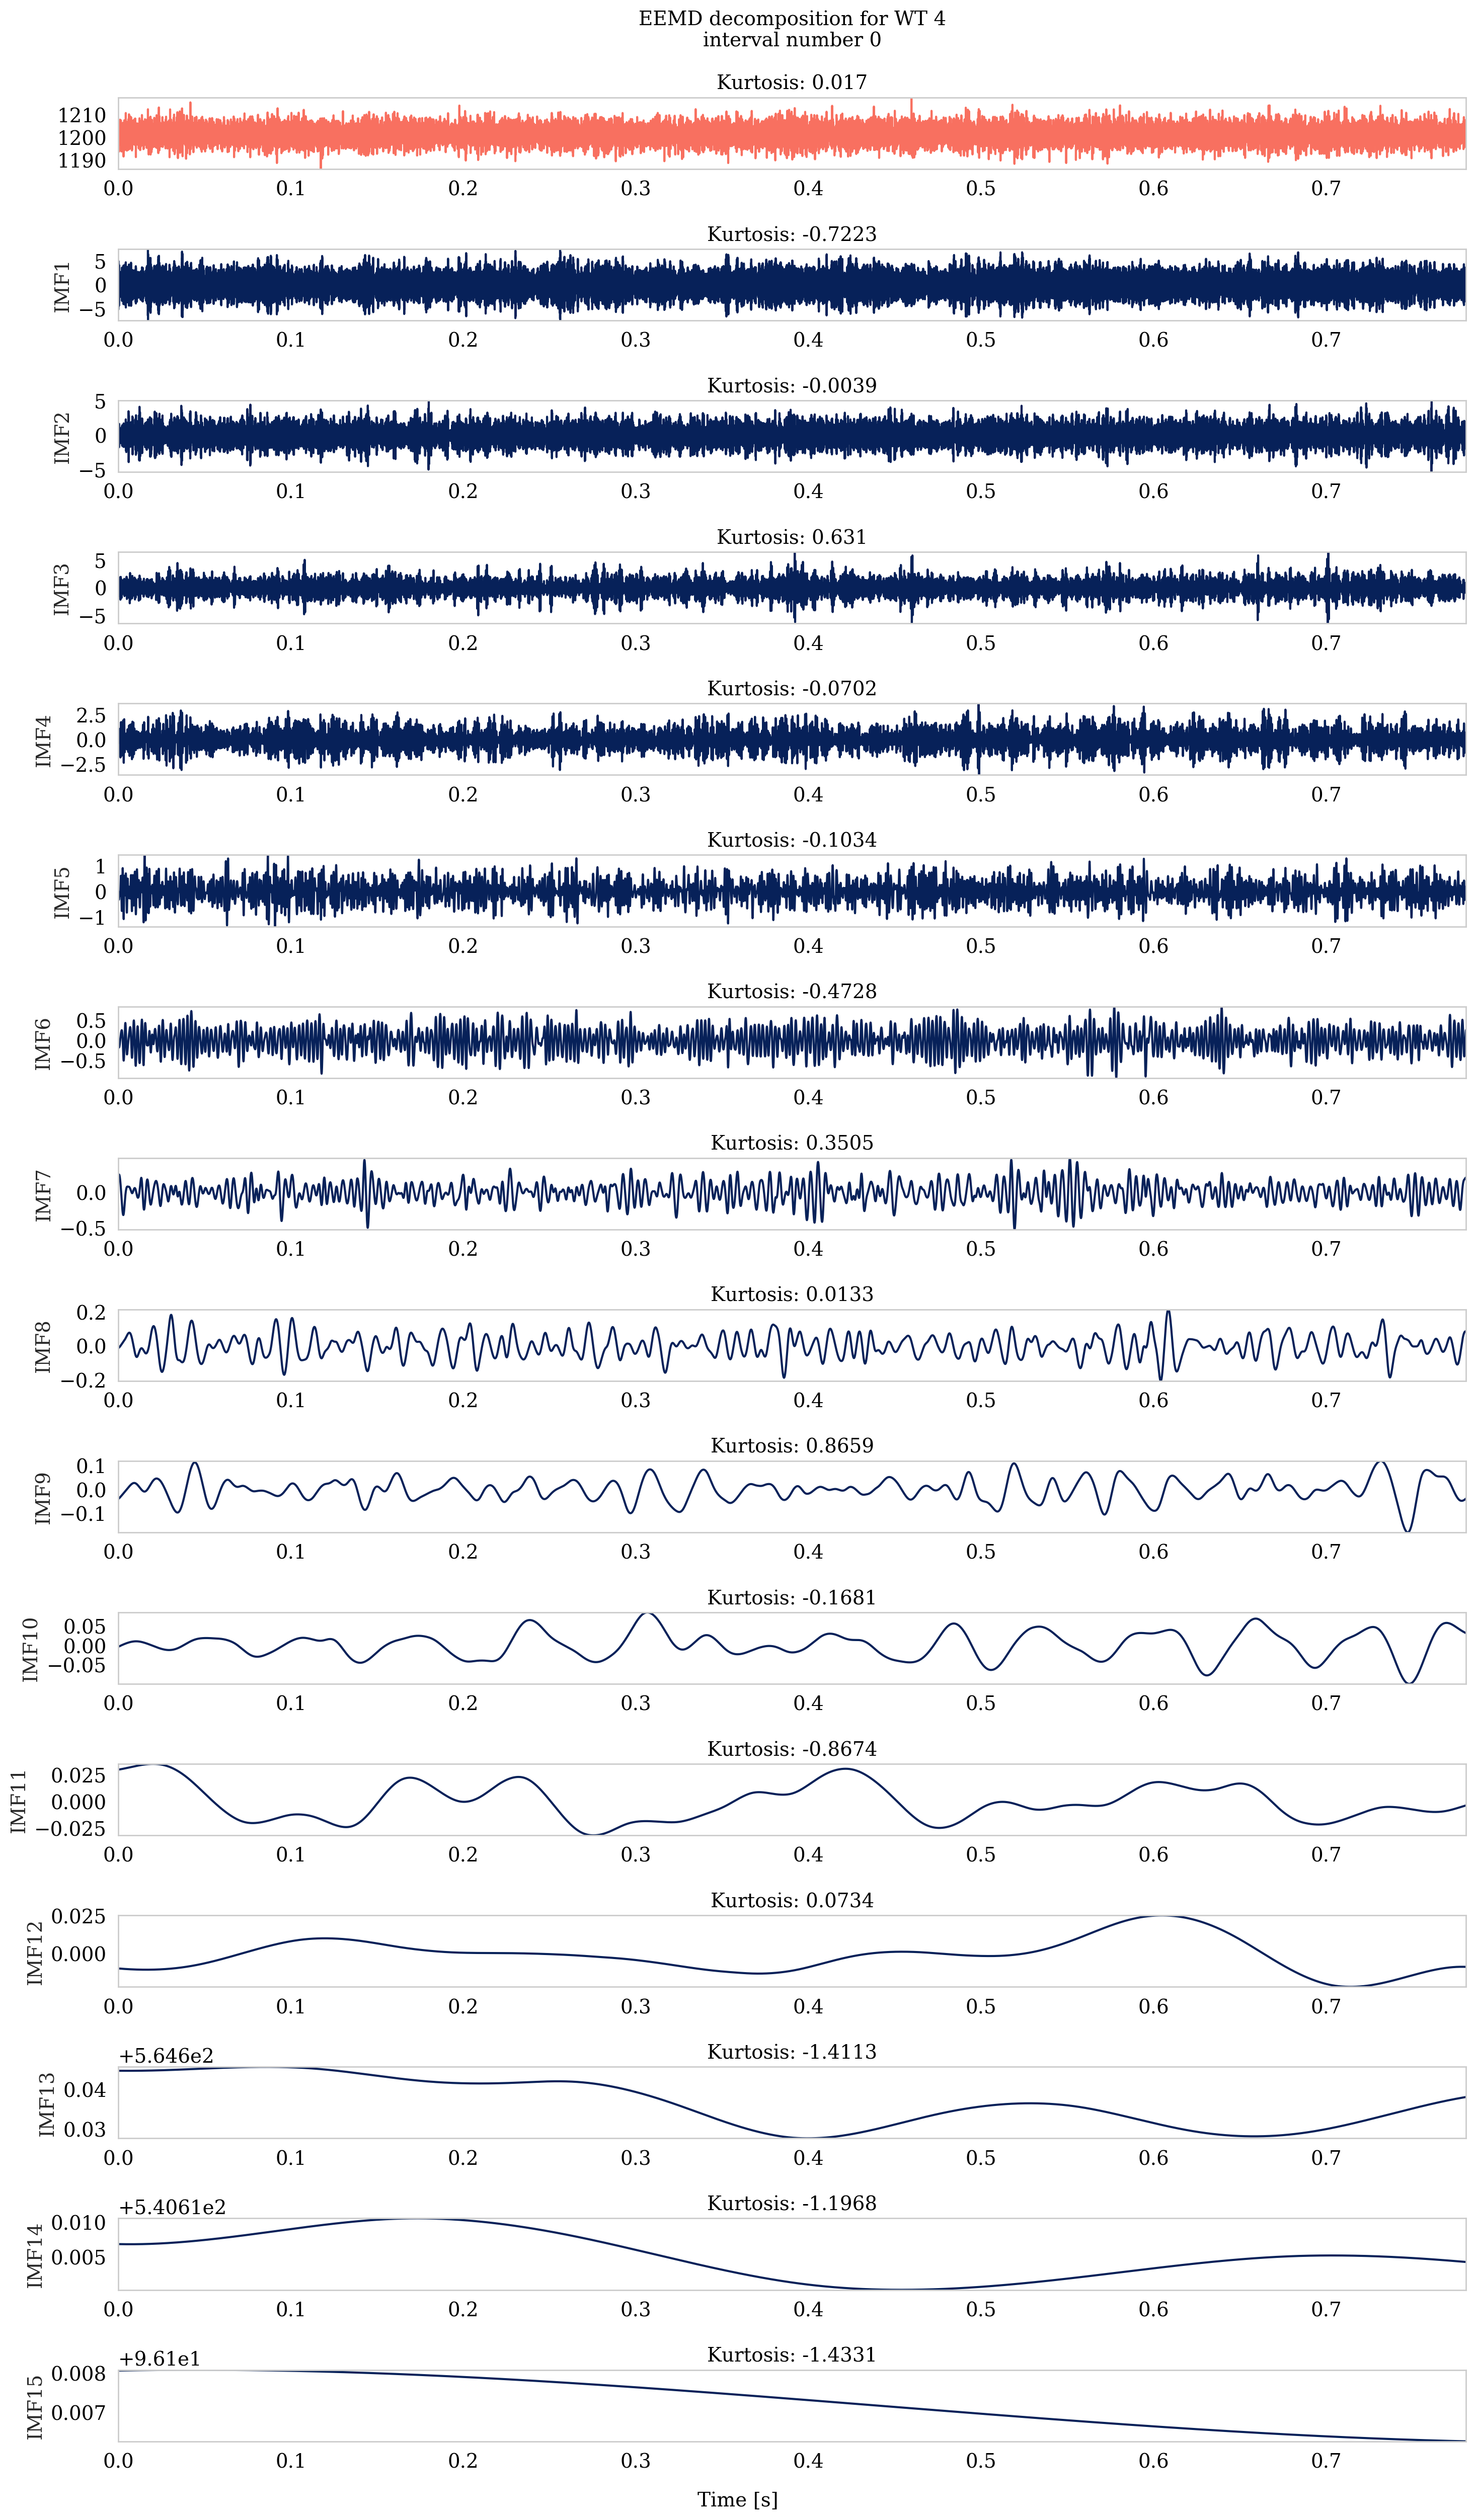

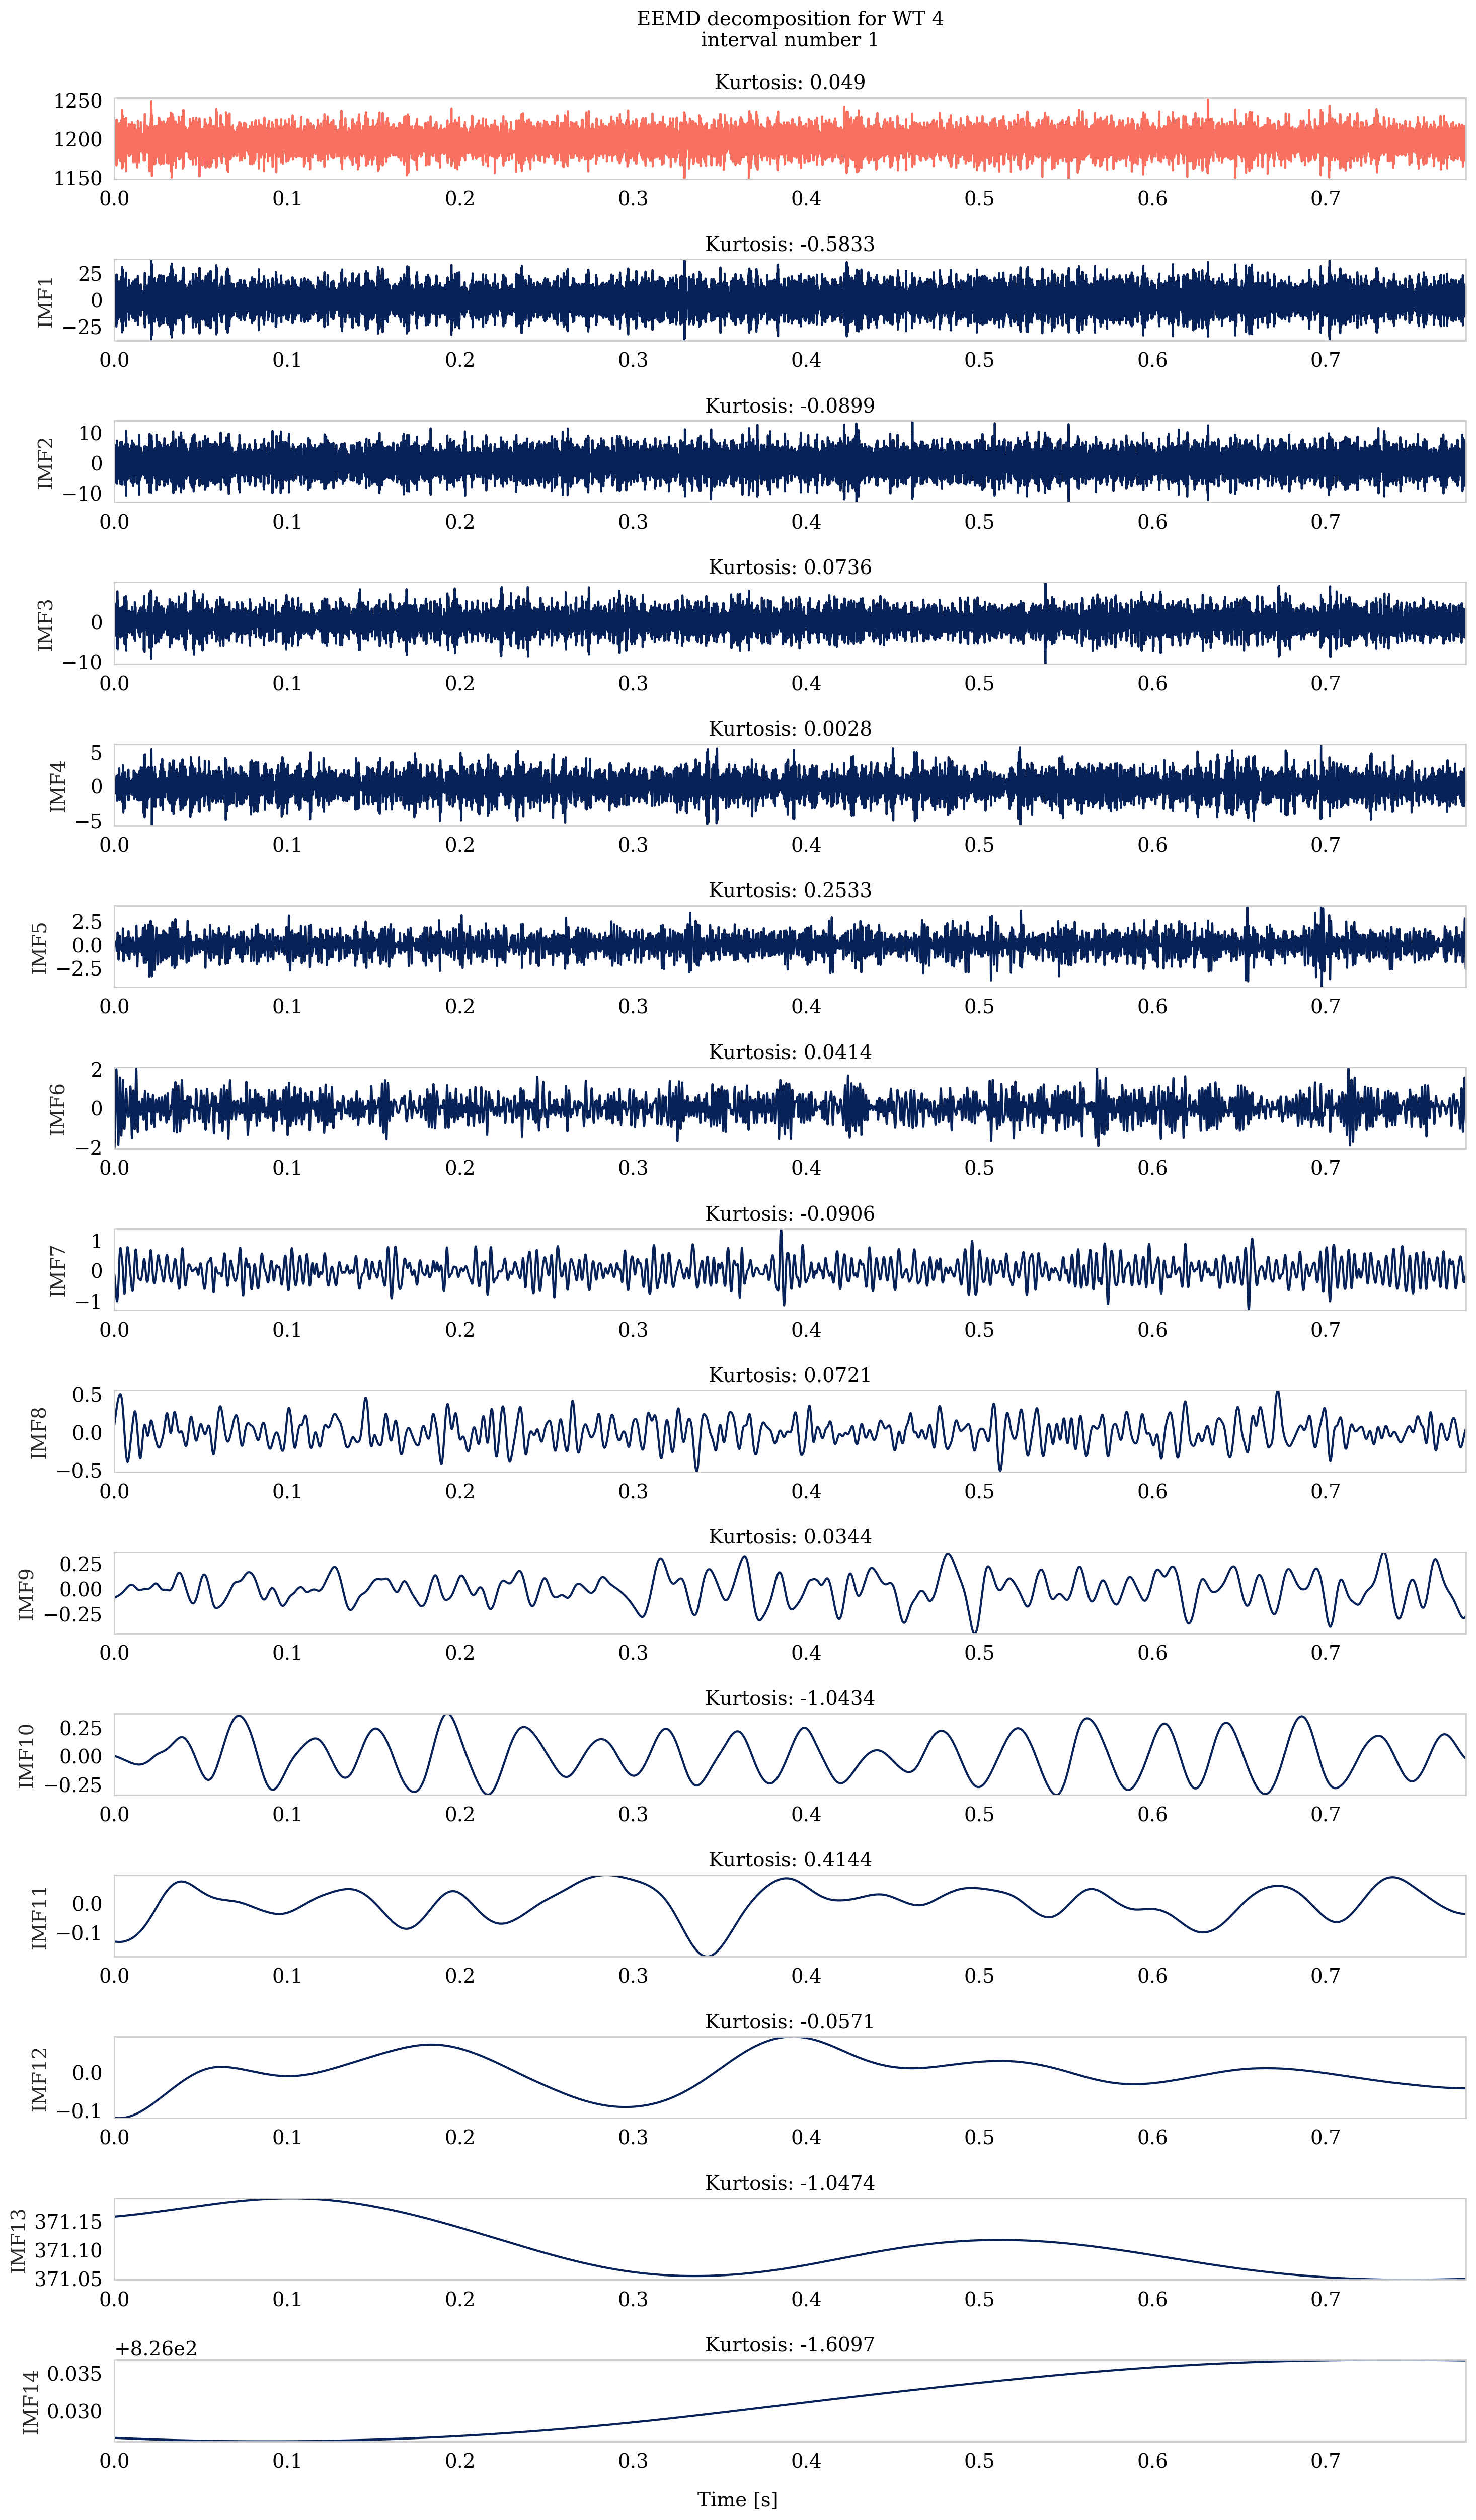

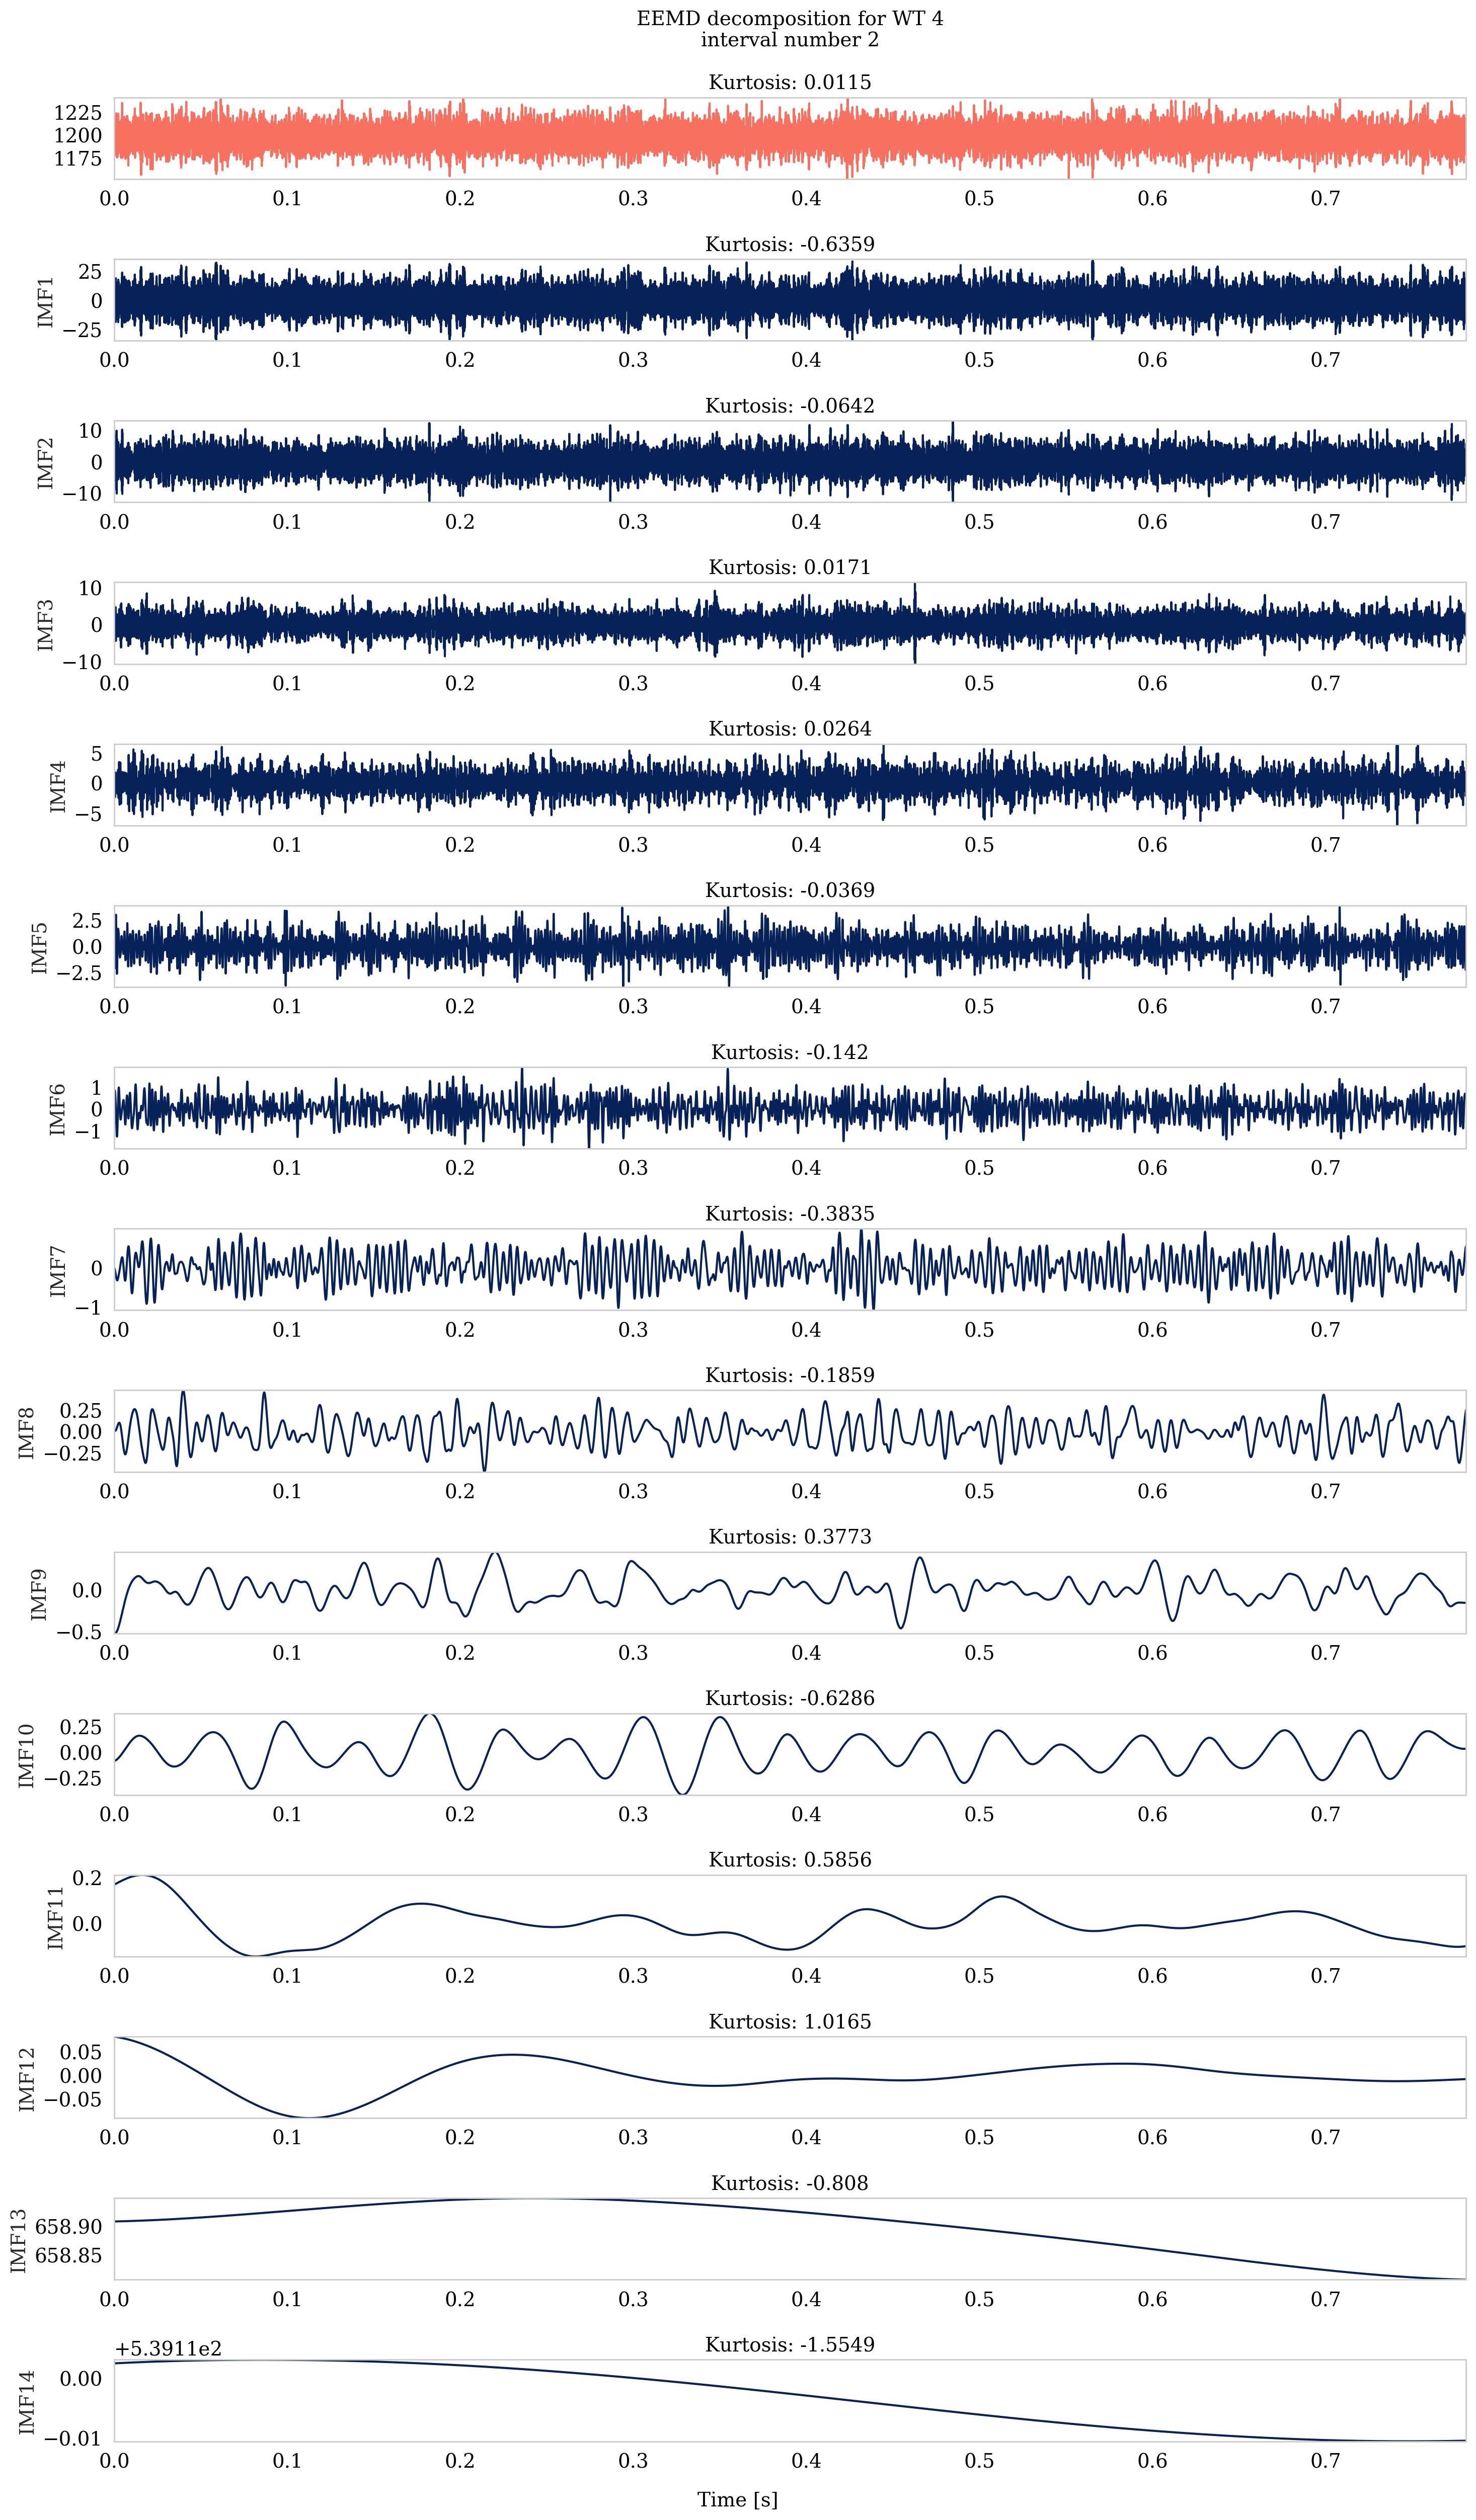

In [53]:
plot_num_intervals=1
plot_eemd.plot_imfs_and_kurtosis(raw_imfs_path,'eemd_wt04_interval_00',times,'zip',plot_num_intervals)

In [7]:
def get_imf_features(path_folder,input_file_type):

    result_features=[]
    
    def calculate_imf_energy(imf):
        imf_energy=0
        for x in imf:
            imf_energy+=(x**2)
        return imf_energy

    file_count = len(glob.glob1(path_folder,"*.zip"))
    print("file count:", file_count)
    
    energy_rates_intervals=[]
    energy_entropies_intervals=[]
    #range(file_count)
    for i in tqdm(range(file_count)): # looping through the intervals
        total_entropy=0

        energy_five_imfs=0 # per interval for the 5 imfs.
        imf_energy_individual={1:0,2:0,3:0,4:0,5:0}
        
        if input_file_type == 'csv':
            path=path_folder + f'interval_number_{i}.csv'
            df = pd.read_csv(path, header=None)
        if input_file_type == 'zip':
            path=path_folder + f'raw_wt04_interval_number_{i}.zip'
            df = pd.read_csv(path,compression='zip')
        # do something with each IMF.. get features?
        
        if (df.shape[0]) < 6:
            print('There are not enought IMFs...')
            break
                    
        # looping through every IMF:
        imf_energy=0
        for imf_index in range(6):
            '''
                Looping through the first 5 IMFs in the interval.
                We are only interested in the first 5 IMFs.
                The first one is the original input signal.
            '''
            if imf_index == 0:
                # this is the original signal, which we are not working with
                continue
                
            imf_energy=calculate_imf_energy(df.iloc[imf_index,:]) # (1) calc energy for imf 
            imf_energy_individual[imf_index]=imf_energy
            energy_five_imfs+=imf_energy # (2) updating energy for the first 5 imfs.
        # after the for-loop:
        energy_rates=[]
        energy_entropy=[] # energyEntropy1,...,energyEntropy5
        for k,imf_energy_value in imf_energy_individual.items():
            p=imf_energy_value/((abs(energy_five_imfs)))
            energy_rates.append(p)
            imf_energy_entropy = -p*np.log(p)
            energy_entropy.append(imf_energy_entropy) # the energy entropy for one interval []
        energy_rates_intervals.append(energy_rates) # energy_rates:[E1/E,E2/E,...,E5/E]            
        energy_entropies_intervals.append(energy_entropy)
    return energy_rates_intervals,energy_entropies_intervals

## Loading the time-frequency features

In [10]:
file_path = '/Volumes/OsvikExtra/signal_data/features/wt04/time_freq_features.csv' 
if os.path.isfile(file_path):
    time_freq_features = pd.read_csv(file_path)
    time_freq_features=time_freq_features.drop(['Unnamed: 0'],axis=1)
    print('Loaded csv.')

else:
    raw_imfs_path='/Volumes/OsvikExtra/signal_data/raw_data/gearbox/wt04/eemds/'
    energy_rates,energy_entropies = get_imf_features(raw_imfs_path,'zip')

    # save the reates and entropies:
    df1 = pd.DataFrame(energy_rates,columns=['imf_rate_1','imf_rate_2','imf_rate_3','imf_rate_4','imf_rate_5'])
    df2 = pd.DataFrame(energy_entropies,columns=['imf_entropy_1','imf_entropy_2','imf_entropy_3','imf_entropy_4','imf_entropy_5'])

    print(df1.shape)
    print(df2.shape)

    time_freq_features = pd.concat([df1,df2],axis=1)
    time_freq_features.to_csv('/Volumes/OsvikExtra/signal_data/features/wt04/time_freq_features.csv')

Loaded csv.


In [11]:
time_freq_features

imf_rate_1  imf_rate_2  imf_rate_3  imf_rate_4  imf_rate_5  \
0      0.557212    0.157598    0.176717    0.091670    0.016803   
1      0.860910    0.078365    0.037746    0.016398    0.006580   
2      0.846519    0.078544    0.042036    0.023967    0.008934   
3      0.857443    0.078703    0.037294    0.019931    0.006629   
4      0.819021    0.089968    0.045235    0.035535    0.010240   
..          ...         ...         ...         ...         ...   
419    0.863631    0.077018    0.038811    0.015888    0.004652   
420    0.852929    0.077006    0.039393    0.023558    0.007114   
421    0.858689    0.070978    0.038648    0.024891    0.006794   
422    0.539799    0.139407    0.177055    0.125538    0.018201   
423    0.812188    0.077470    0.039623    0.060265    0.010454   

     imf_entropy_1  imf_entropy_2  imf_entropy_3  imf_entropy_4  imf_entropy_5  
0         0.325863       0.291195       0.306287       0.219051       0.068661  
1         0.128934       0.199547       0.123689       0.067405       0.033058  
2         0.141049       0.199823       0.133223       0.089423       0.042151  
3         0.131875       0.200069       0.122657       0.078038       0.033254  
4         0.163514       0.216670       0.140043       0.118589       0.046916  
..             ...            ...            ...            ...            ...  
419       0.126617       0.197453       0.126098       0.065812       0.024984  
420       0.135683       0.197433       0.127404       0.088303       0.035183  
421       0.130820       0.187764       0.125732       0.091929       0.033915  
422       0.332818       0.274682       0.306534       0.260510       0.072917  
423       0.168954       0.198158       0.127917       0.169285       0.047678  

[424 rows x 10 columns]

# Time and frequency features
## highpassed signal

### bispectrum for one RAW signal

In [12]:
vib_signal, _, _, _ = load_raw_signals.load_raw('gearbox','wt04')

File exist


## Plotting bi-spectrum for one interval (Raw signal)

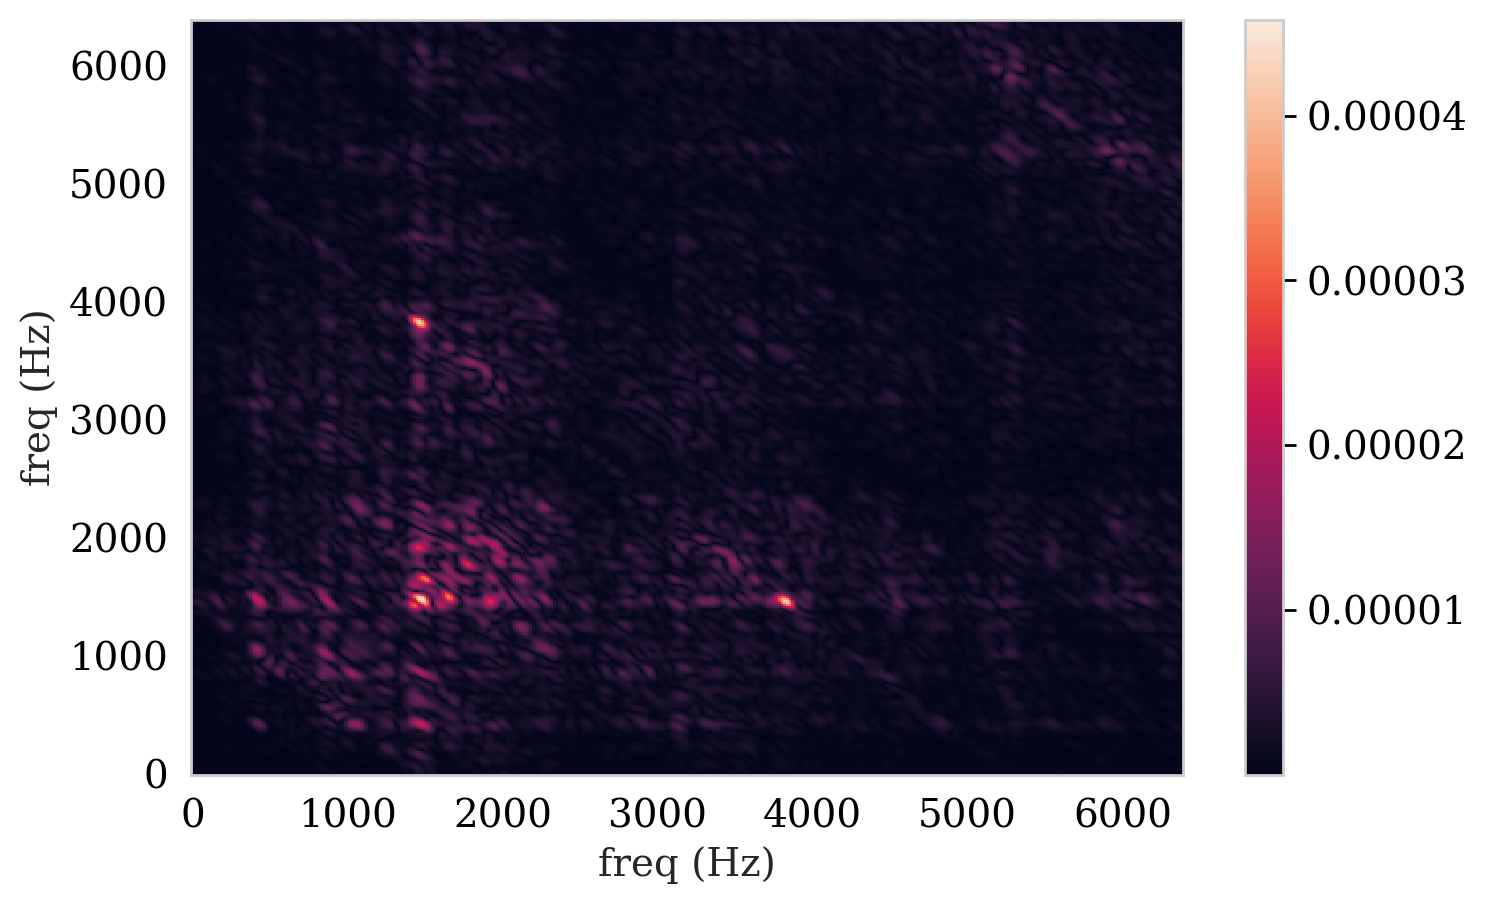

(375, 375)


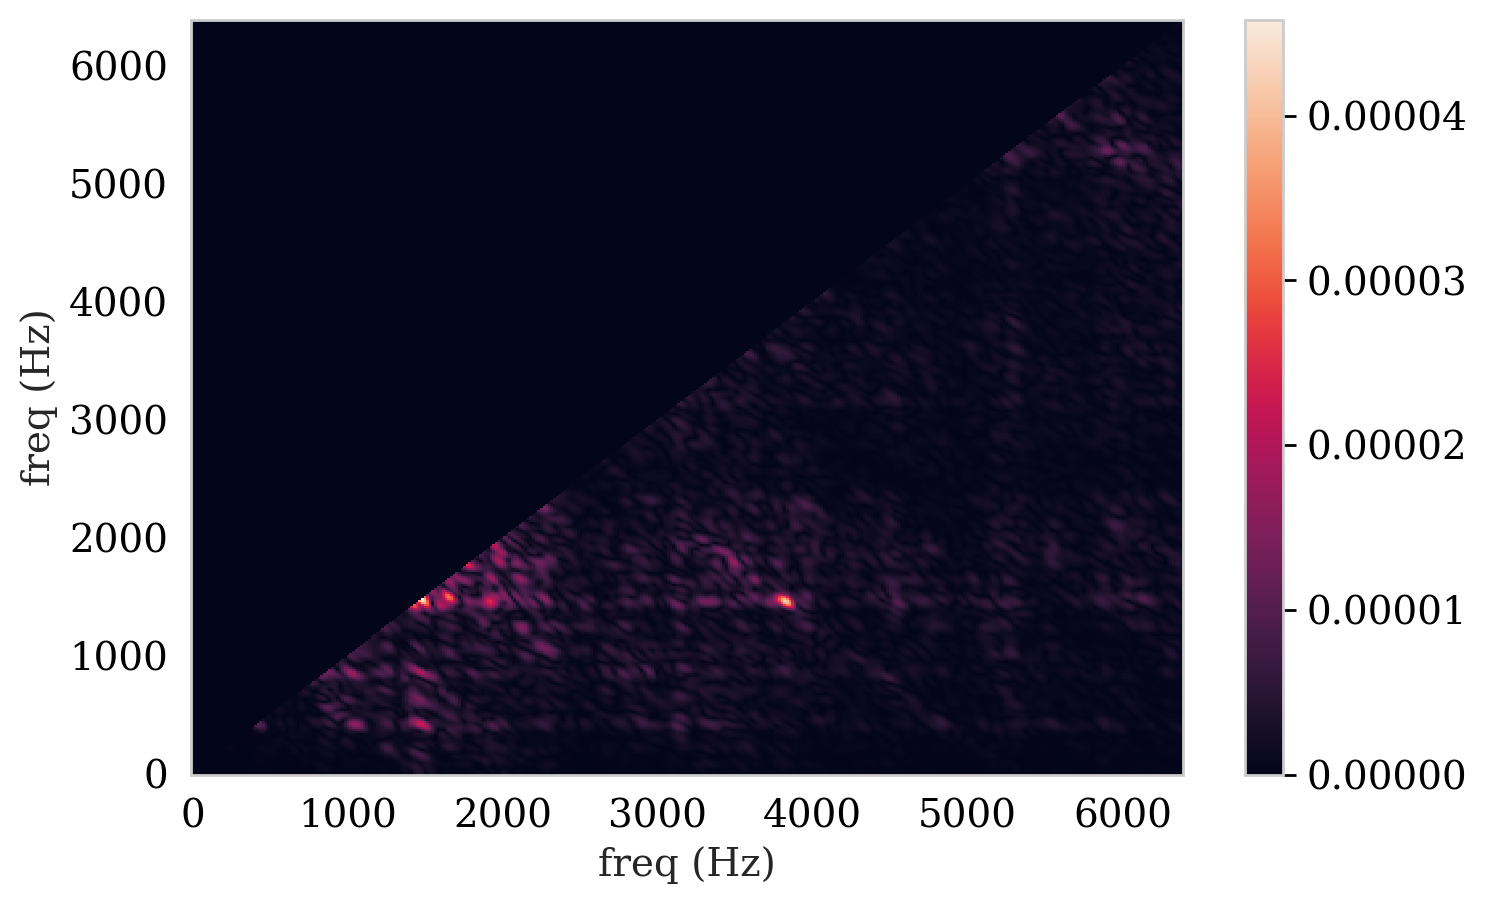

In [14]:
from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

sig=vib_signal[0][0:3000]
fs = 25600

N=10000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part
polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
plt.show()

In [15]:
# Loading the highpassed signal:
# Reading filtered from disk
filtered_path = '/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/filtered/'

num_csvs = len([f for f in os.listdir(filtered_path) 
     if f.endswith('.csv') and os.path.isfile(os.path.join(filtered_path, f)) and f[0]=='f'])

filtered_signals = []
filtered_freqs = []
columns = []
for i in tqdm(range(num_csvs)):
    acc=pd.read_csv(filtered_path+'filtered_raw_6000_'+str(i)+'.csv')
    columns.append('filtered_' + str(i))
    filtered_signals.append(acc.values.T[0])
    filtered_freqs.append(acc.shape[0] / times[i][-1])
    print(f'Reading {i} / {num_csvs} files', end='\r')

Reading 423 / 424 files


## Plotting bi-spectrum for one interval (HP 6000 Hz filtered)

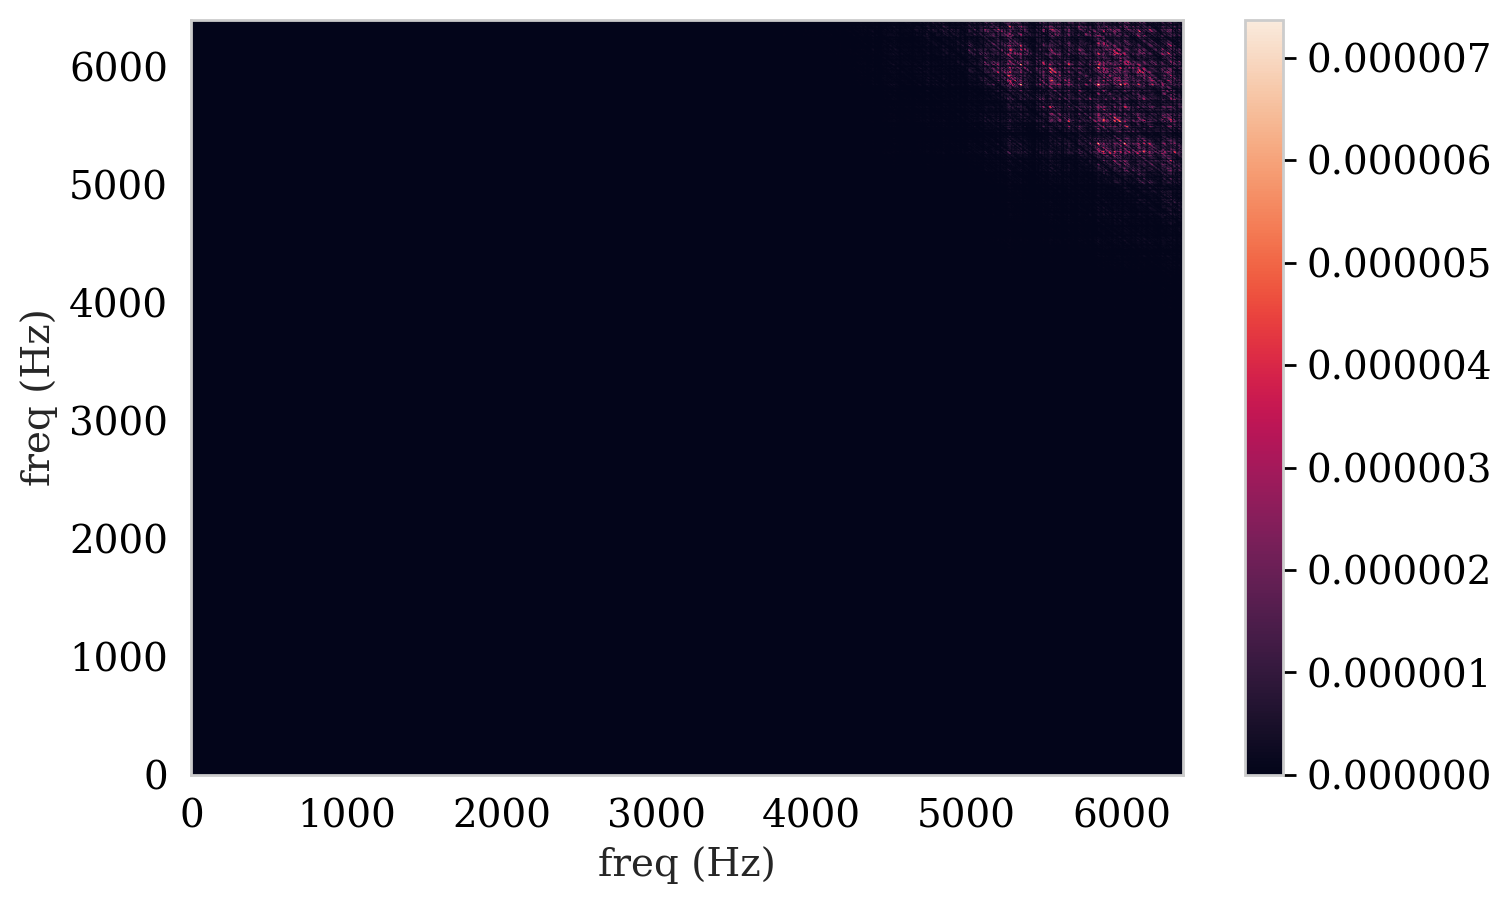

(2500, 2500)


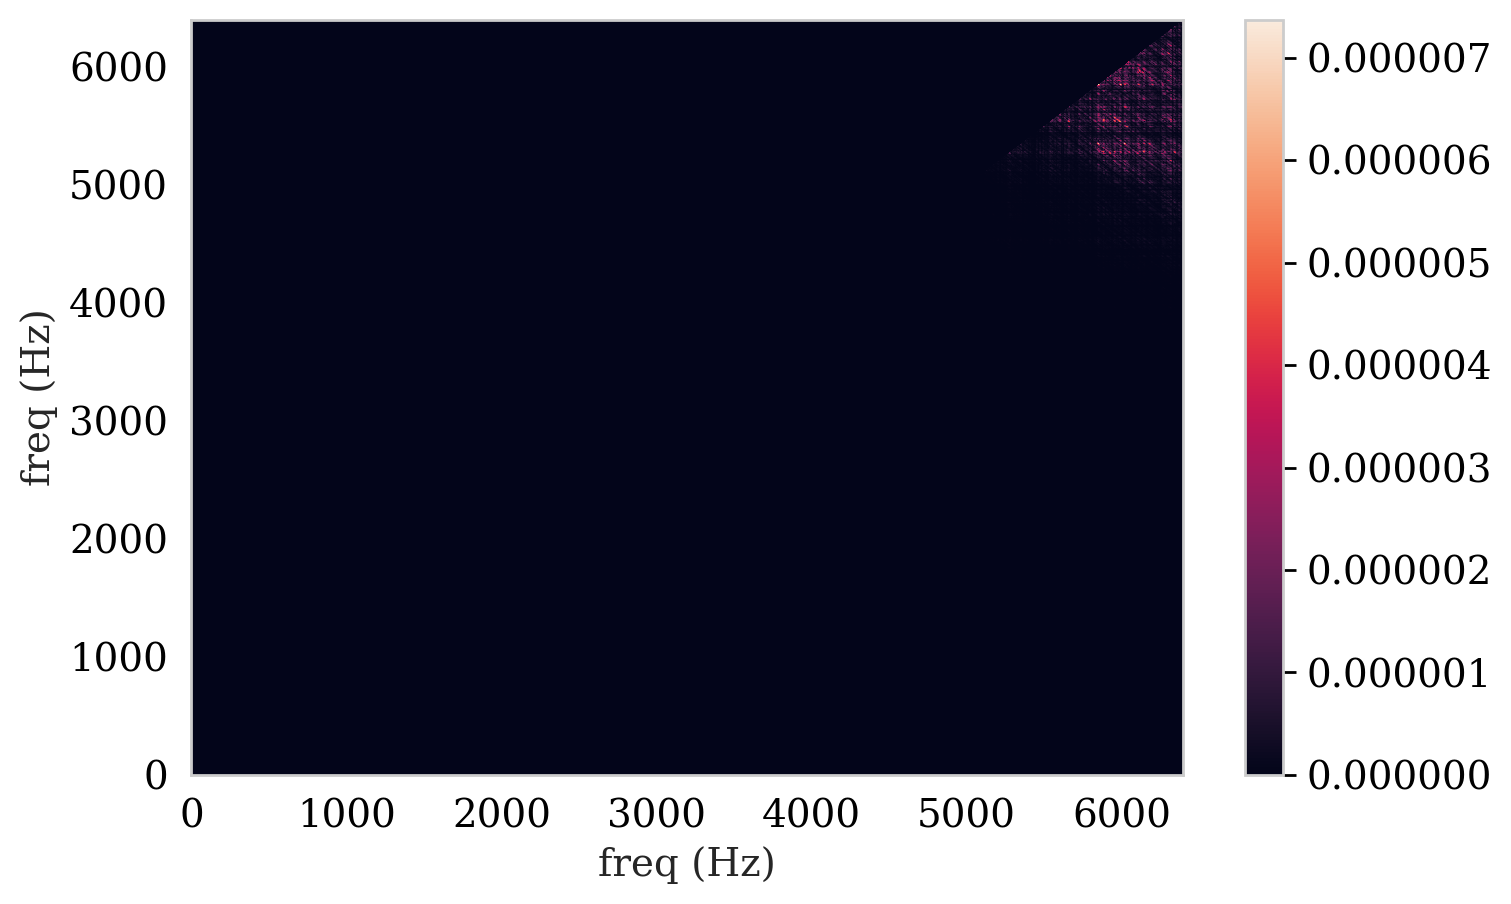

In [151]:
from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

sig=filtered_signals[0][0:3000] # selecting to be stationary

N=20000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part


polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
plt.show()

(1500, 1500)


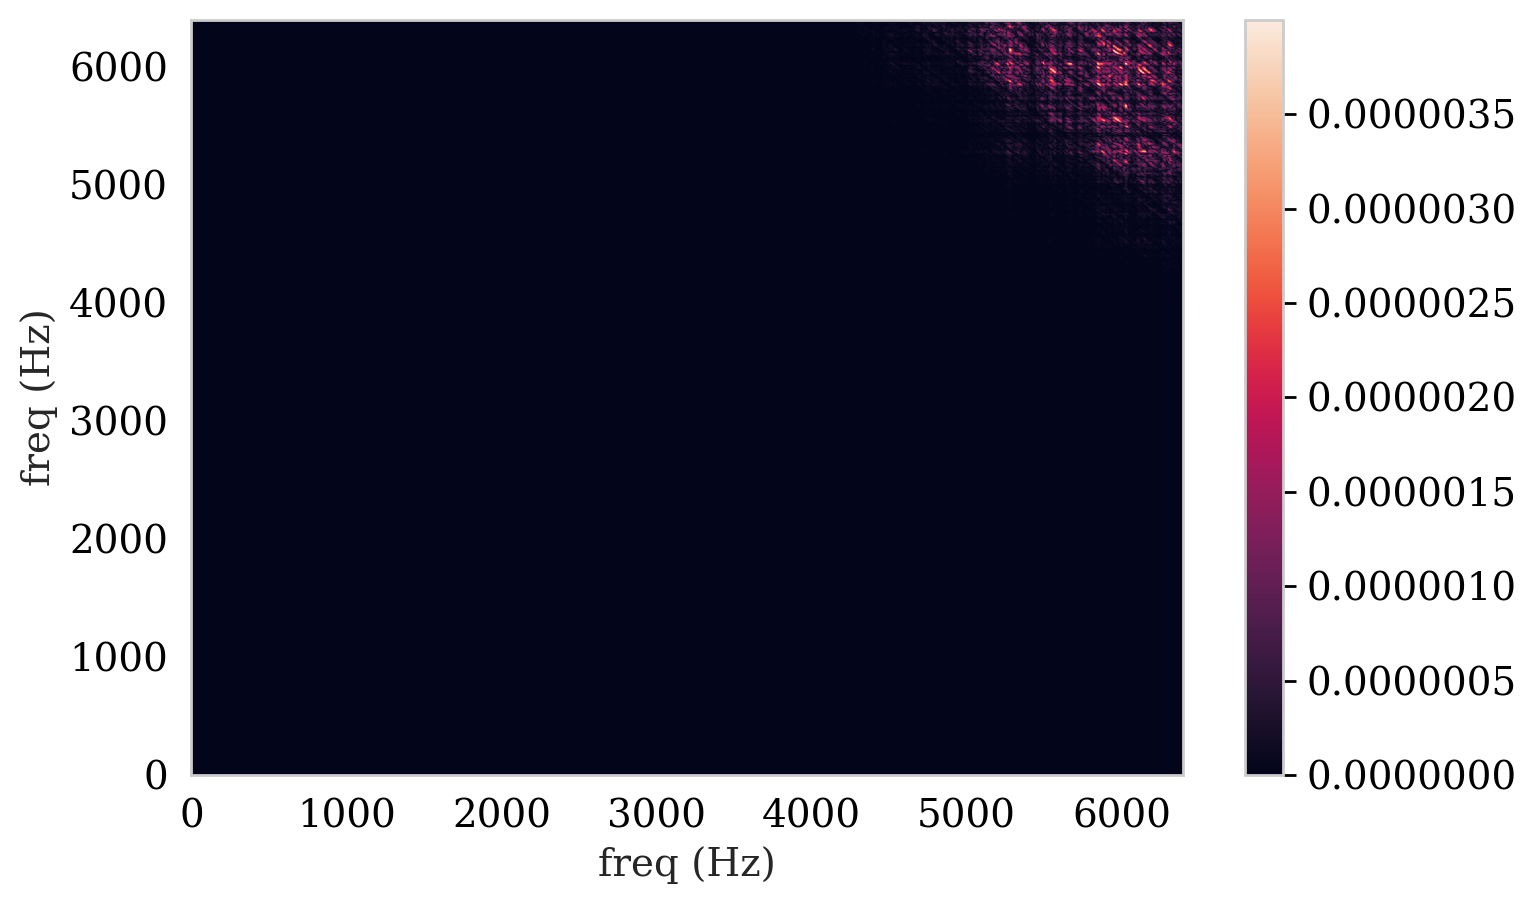

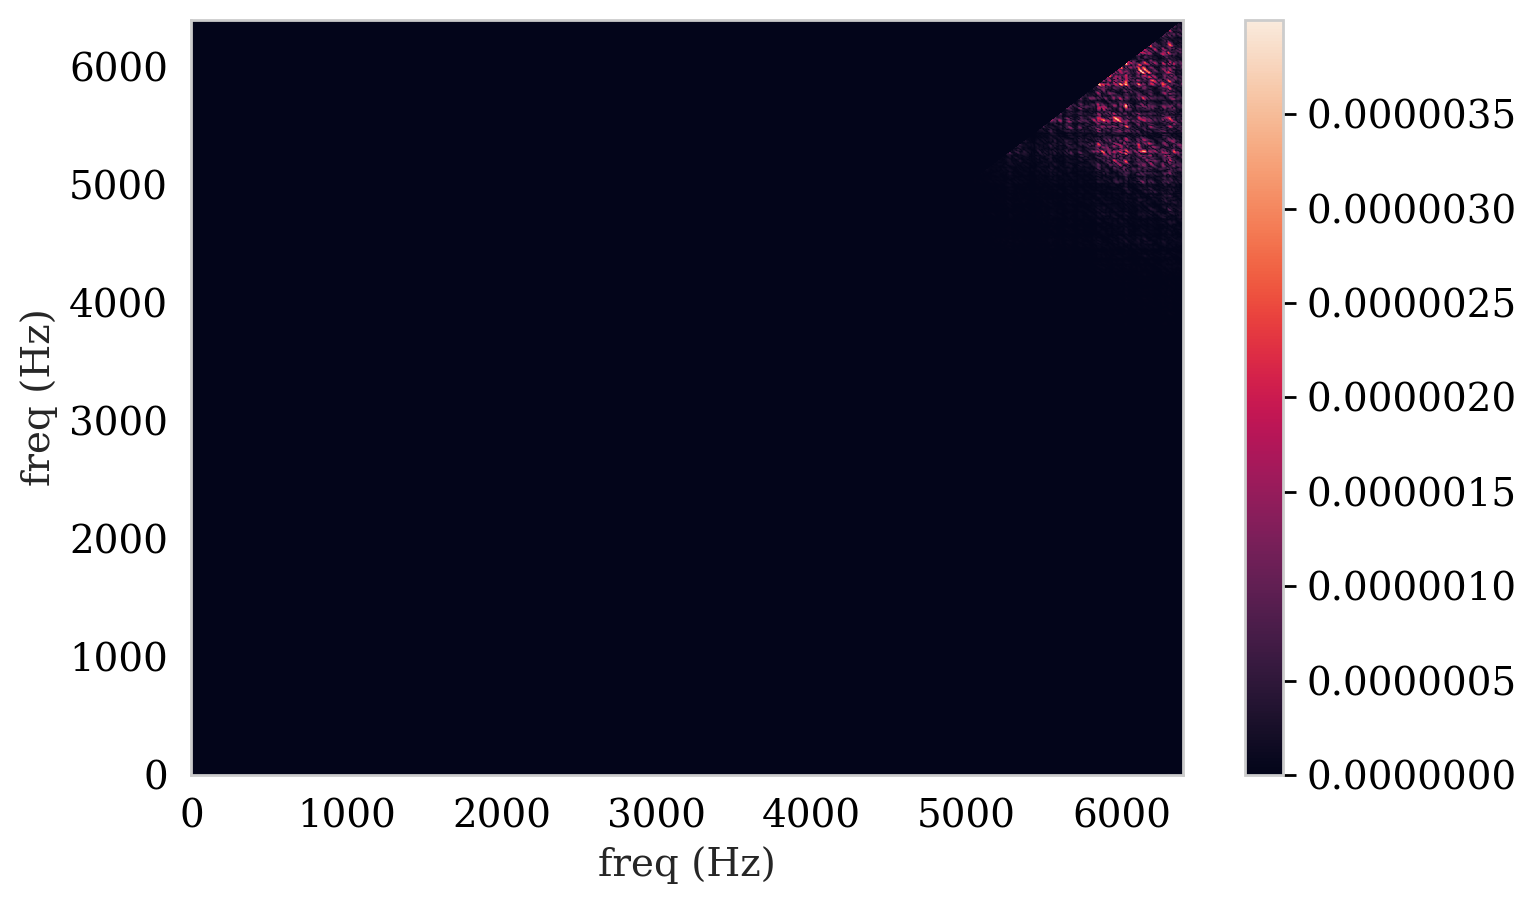

In [189]:
'''
def num_of_zeros(array):
    sh = (array.shape)
    non = np.count_nonzero(array==0)
    print("non",non)
    zero_elems = sh[0]*sh[1] - non
    print(zero_elems)
    
num_of_zeros(bispec_half)
zeros = np.count_nonzero(bispec_half)
items=(bispec_half.shape[0]*bispec_half.shape[1])

print(f'zeros before func {items-zeros}')

print(f'Number of elements are {items}')

import numpy as np

def myfunc(a):
    if  abs(a) < 10**(-7):
        return (0+0j)
    else:
        return a
    
vfunc = np.vectorize(myfunc)
bispec_half=vfunc(bispec_half)


print("ELEM",bispec_half[200,500])


zeros = np.count_nonzero(bispec_half)
print('zeros after func',items-zeros)

polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
'''

from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

sig=filtered_signals[0][0:3000] # selecting to be stationary

N=12000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
#plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part
polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
plt.show()


l=list(bispec[np.triu_indices_from(bispec)])


# l=list(bispec[])


#l=list(bispec[np.triu_indices(bispec)])
# l

In [208]:
sig

array([-4.57777821,  6.23560111, -5.3072875 , ...,  5.3272846 ,
       -3.78612955,  2.62619509])

In [209]:
f=feature_extraction.get_freq_domain_features(sig,fs,20000,False)
x=(np.asarray(bispec_half))
(pd.DataFrame(x))

0                           1     \
0     5.577524e-12+0.000000e+00j  5.031927e-12-7.555534e-19j   
1     0.000000e+00+0.000000e+00j  4.068128e-12+6.268044e-19j   
2     0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
3     0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
4     0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
...                          ...                         ...   
1495  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1496  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1497  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1498  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1499  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   

                            2                           3     \
0     3.645540e-12+5.421011e-20j  2.016652e-12-2.625802e-20j   
1     2.575389e-12+5.738648e-18j  1.161150e-12+1.654340e-17j   
2     1.328825e-12+2.159934e-17j  3.721041e-13+4.304582e-17j   
3     0.000000e+00+0.000000e+00j -9.359730e-14+6.464582e-17j   
4     0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
...                          ...                         ...   
1495  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1496  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1497  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1498  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1499  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   

                            4                           5     \
0     7.410596e-13-5.421011e-20j  1.050454e-13-3.412120e-24j   
1     2.650096e-13+2.689929e-17j -3.374335e-14+2.713711e-17j   
2    -7.628513e-14+5.361004e-17j -1.014802e-13+4.237666e-17j   
3    -2.004720e-13+6.380233e-17j -9.587582e-14+3.922604e-17j   
4    -1.543684e-13+4.966159e-17j -5.229842e-14+2.254296e-17j   
...                          ...                         ...   
1495  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1496  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1497  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1498  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1499  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   

                            6                           7     \
0     1.201451e-14+8.404155e-22j  1.499909e-13-1.021733e-20j   
1     4.032108e-14+1.559116e-17j  1.809692e-13+1.921653e-18j   
2     4.359527e-14+1.730482e-17j  1.386076e-13+3.692005e-19j   
3     2.917711e-14+1.129102e-17j  6.672790e-14+4.173465e-18j   
4     1.144826e-14+4.976840e-18j  1.199675e-14+1.049731e-17j   
...                          ...                         ...   
1495  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1496  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1497  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1498  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   
1499  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j   

                            8                           9     ...  \
0     2.420202e-13-1.344665e-20j  1.959696e-13-1.344665e-20j  ...   
1     2.068553e-13-1.660185e-18j  1.204817e-13+7.495305e-18j  ...   
2     1.139636e-13+6.164894e-18j  3.041445e-14+2.701678e-17j  ...   
3     2.513888e-14+2.209006e-17j -2.704395e-14+4.477090e-17j  ...   
4    -1.821851e-14+3.056497e-17j -3.670096e-14+4.327260e-17j  ...   
...                          ...                         ...  ...   
1495  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  ...   
1496  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  ...   
1497  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  ...   
1498  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  ...   
1499  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  ...   

                            1490                        1491  \
0    -9.683307e-09+4.475587e-16j -7.026136e-09-5.551115e-17

In [211]:
f

([-98027540.0,
  -81092.484,
  -76106175.97758579,
  11.722031593322754,
  nan,
  (2285.812915373408-104.02604950737832j),
  (2336.9165941485003-58.10485232629568j)],
 ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
 ['Bispectrum Log Amplitude',
  'Bispectrum Log Amplitude Diagonal',
  'Bispectrum First order Spectral Moment Diagonal',
  'Bispectrum Normalized Entropy',
  'Normalized bi-spectral squared entropy',
  'Bispectrum Weigheted Sum First axis',
  'Bispectrum Weigheted Sum Second axis'])

# Features

In [108]:
# getting time features and bi-spectrum features
feature_df=feature_extraction.generate_feature_df(1,25600,op_data_intervals,filtered_signals)

KeyboardInterrupt: 

In [ ]:
feature_df=pd.concat([feature_df, time_freq_features],axis=1)

In [ ]:
feature_df

In [ ]:
# Clustering

cluster_labels,cluster_map = clustering.db_scan_clustering(feature_df,'raw',eps=0.31) # Cluster the points
clustering.plot_clusters(cluster_labels) # plot the clusters
clustering.plot_clusters_pair_plot(feature_df, ['AvgSpeed','rms','B4'],cluster_labels) # pair plot